In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score #Confusion matrix
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

C:\Users\lockd\anaconda3\envs\pyTest\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\lockd\anaconda3\envs\pyTest\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\lockd\anaconda3\envs\pyTest\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
fold_titanic = pd.read_csv("titanic_train.csv")

### 데이터 살펴보기

In [3]:
fold_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
fold_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* sibsp : 타이타닉호에 탑승한 형제자매/배우자 수
* parch : 타이타닉호에 탑승한 부모/자녀 수

#### 각 컬럼 요소 살펴보기

In [5]:
fold_titanic['Pclass'].unique()

array([3, 1, 2], dtype=int64)

In [6]:
fold_titanic['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [7]:
fold_titanic['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6], dtype=int64)

In [14]:
fold_titanic['Embarked'].unique()

array(['C', 'S', 'Q'], dtype=object)

In [8]:
fold_titanic['Sex'].unique()

array(['male', 'female'], dtype=object)

### EDA

#### 전반적인 생존 비율

In [3]:
fold_titanic['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

=> 생존률 약 40%를 기준으로 이상치가 있는지 살펴보자

In [4]:
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import platform

#한글폰트 가져오기
plt.rcParams['axes.unicode_minus']=False

path = "c:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)

Text(0.5, 1.0, 'SibSp')

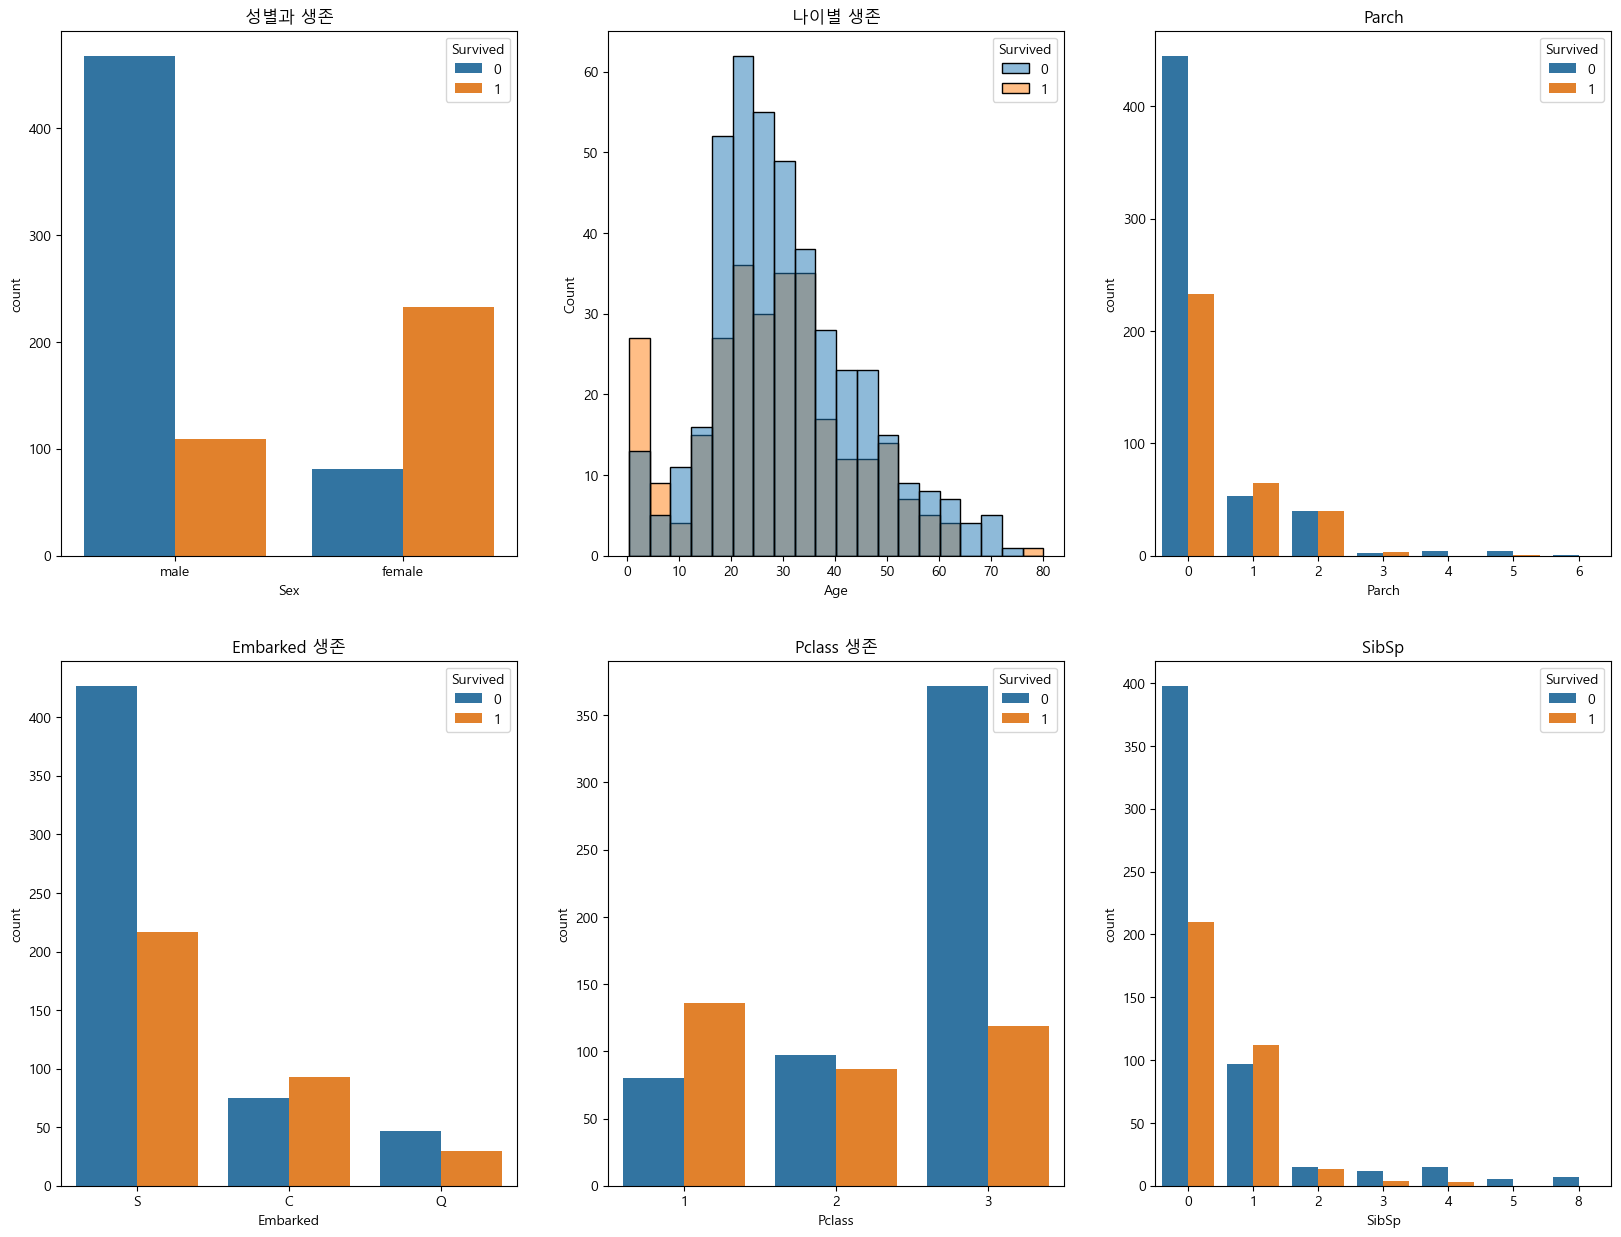

In [5]:
import seaborn as sns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))

#성별과 생존
sns.countplot(data=fold_titanic, x='Sex', hue='Survived', ax=axes[0,0])
axes[0,0].set_title('성별과 생존')

#나이별 생존
sns.histplot(data=fold_titanic, x='Age', hue='Survived',ax=axes[0,1])
axes[0,1].set_title('나이별 생존')

#Parch
sns.countplot(data=fold_titanic, x='Parch', hue='Survived', ax=axes[0,2])
axes[0,2].set_title('Parch')

#Emabarked C = Cherbourg, Q = Queenstown, S = Southampton
sns.countplot(data=fold_titanic, x='Embarked', hue='Survived', ax=axes[1,0])
axes[1,0].set_title('Embarked 생존')

#Pclass
sns.countplot(data=fold_titanic, x='Pclass', hue='Survived', ax=axes[1,1])
axes[1,1].set_title('Pclass 생존')

#SibSp
sns.countplot(data=fold_titanic, x='SibSp', hue='Survived', ax=axes[1,2])
axes[1,2].set_title('SibSp')


#### 시사점
- 남자에 비해 여자의 생존률이 더 높다
- 나이가 아주 어리거나 아주 많은 경우 생존률이 높다
- 형제자매나 배우자와 함께 탄 경우  생존률이 높다
- 셰르부르에서 승선한 경우에 생존률이 가장 높다. 그 다음은 퀸스타운
- 1등급 티켓 소유자가 가장 생존률이 높다. 등급은 높을수록 생존률이 좋음
- 부모나 자녀 둘이 탄 경우가 생존률이 가장 높다. 너무 많으면 생존률이 적음

### 데이터 정제

**범주형 데이터 처리**

In [6]:
fold_titanic.loc[(fold_titanic['Sex']=='male'), 'Sex'] = 0
fold_titanic.loc[(fold_titanic['Sex']=='female'), 'Sex'] = 1

In [7]:
fold_titanic['Embarked'].value_counts(normalize=True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

In [8]:
fold_titanic.loc[(fold_titanic['Embarked']=='S'), 'Embarked'] = 0.724409
fold_titanic.loc[(fold_titanic['Embarked']=='C'), 'Embarked'] = 0.188976
fold_titanic.loc[(fold_titanic['Embarked']=='Q'), 'Embarked'] = 0.086614

In [9]:
fold_titanic['Sex'] = fold_titanic['Sex'].astype(object).astype(int)
fold_titanic['Embarked'] = fold_titanic['Embarked'].astype(object).astype(float)

**필요한 컬럼만 선택**

In [10]:
titanic_pick = fold_titanic[["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","Survived"]]

**결측치 제거**

In [11]:
titanic_pick=titanic_pick.dropna()

**인덱스 재설정**

In [12]:
titanic_pick.index=range(1,713)

In [13]:
titanic_pick

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
1,3,0,22.0,1,0,7.2500,0.724409,0
2,1,1,38.0,1,0,71.2833,0.188976,1
3,3,1,26.0,0,0,7.9250,0.724409,1
4,1,1,35.0,1,0,53.1000,0.724409,1
5,3,0,35.0,0,0,8.0500,0.724409,0
...,...,...,...,...,...,...,...,...
708,3,1,39.0,0,5,29.1250,0.086614,0
709,2,0,27.0,0,0,13.0000,0.724409,0
710,1,1,19.0,0,0,30.0000,0.724409,1
711,1,0,26.0,0,0,30.0000,0.188976,1


In [14]:
titanic_pick.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 1 to 712
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Sex       712 non-null    int32  
 2   Age       712 non-null    float64
 3   SibSp     712 non-null    int64  
 4   Parch     712 non-null    int64  
 5   Fare      712 non-null    float64
 6   Embarked  712 non-null    float64
 7   Survived  712 non-null    int64  
dtypes: float64(3), int32(1), int64(4)
memory usage: 41.8 KB


**features X와 label y를 나누기**

In [15]:
features = titanic_pick[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
label = titanic_pick[['Survived']]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size = 0.2, random_state=111)

In [17]:
model = DecisionTreeClassifier()
model_sp1 = DecisionTreeClassifier(random_state=111, max_depth=3)
model.fit(X_train, y_train) #모델학습
model_sp1.fit(X_train, y_train) #모델학습
pred_train = model.predict(X_train) #결정트리 train예측
pred_test = model.predict(X_test)#test 예측

pred_train_sp = model_sp1.predict(X_train) #결정트리 깊이제한 train예측
pred_test_sp = model_sp1.predict(X_test) #test예측

In [18]:
print(accuracy_score(y_train, pred_train)) #훈련데이터 예측 정확도
print(accuracy_score(y_test, pred_test)) #테스트데이터 예측 정확도

0.9859402460456942
0.7832167832167832


- 훈련데이터의 정확도가 테스트 데이터의 정확도보다 높다
  -> 과적합

In [19]:
#결정트리의 깊이를 제한한 훈련의 정확도
print(accuracy_score(y_train, pred_train_sp))
print(accuracy_score(y_test, pred_test_sp))

0.8224956063268892
0.8111888111888111


- 훈련데이터의 정확도가 감소했으나 테스트 데이터의 정확도가 올라갔다
- 훈련데이터와 테스트데이터의 예측 정확도 차이가 크지 않다
- 과적합이 해소되었다

### 교차검증 추가하기

In [20]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5) #데이터셋 분리

cv_accuracy_train = []
cv_accuracy_test = []
kf_model = DecisionTreeClassifier(random_state=111,max_depth=3)

In [21]:
kfold

KFold(n_splits=5, random_state=None, shuffle=False)

In [22]:
n_iter = 0 #5번 진행하니 초깃값 설정

for train_idx, test_idx in kfold.split(features):
    X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
    y_train, y_test = label.iloc[train_idx], label.iloc[test_idx]
    
    #학습을 위해서 dt배우기
    kf_model.fit(X_train, y_train)
    #예측
    kf_pred_train = kf_model.predict(X_train)
    df_pred_test = kf_model.predict(X_test)
    
    #정확도를 5번 측정하면서 값에 넣을 것이니
    n_iter +=1
    accuracy_train = np.round(accuracy_score(y_train, kf_pred_train),4)
    accuracy_test = np.round(accuracy_score(y_test, df_pred_test),4)
    
    print('\n{} 번 train 교차 검증 정확도 :{} ,test 교차 검증 정확도 :{} '.format(n_iter,accuracy_train, accuracy_test))
    
    cv_accuracy_train.append(accuracy_train)
    cv_accuracy_test.append(accuracy_test)
    
print('train 평균 정확도',np.mean(cv_accuracy_train))
print('test 평균 정확도',np.mean(cv_accuracy_test))


1 번 train 교차 검증 정확도 :0.8172 ,test 교차 검증 정확도 :0.8182 

2 번 train 교차 검증 정확도 :0.8102 ,test 교차 검증 정확도 :0.7972 

3 번 train 교차 검증 정확도 :0.8281 ,test 교차 검증 정확도 :0.7887 

4 번 train 교차 검증 정확도 :0.8333 ,test 교차 검증 정확도 :0.7676 

5 번 train 교차 검증 정확도 :0.807 ,test 교차 검증 정확도 :0.8028 
train 평균 정확도 0.8191600000000001
test 평균 정확도 0.7948999999999999


### Skf 모델 진행
- kfold 문제점은?
- 정답 라벨이 0,1,2 총 3개 -> Kfold는 랜덤하게 데이터를 추출하기 때문에 정답 비중이 고르게 분포하지 않을 수 있다
- 그러다보니 정답레이블이 불균형 또는 다중분류인 경우는 SKF를 통해서 정답 라벨 불균형을 해소

In [25]:
from sklearn.model_selection import StratifiedKFold

skf_titanic = StratifiedKFold(n_splits=3)
cnt_iter=0

In [26]:
skf_titanic

StratifiedKFold(n_splits=3, random_state=None, shuffle=False)

In [27]:
n_iter=0

skf_cv_accuracy_train = []
skf_cv_accuracy_test = []
skf_model = DecisionTreeClassifier(random_state=111, max_depth=3)

for train_idx, test_idx in skf_titanic.split(features, label):
    X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
    y_train, y_test = label.iloc[train_idx], label.iloc[test_idx]
    
    #학습을 위해서 dt배우기
    skf_model.fit(X_train, y_train)
    #예측
    skf_pred_train = skf_model.predict(X_train)
    skf_pred_test = skf_model.predict(X_test)
    
    #정확도를 5번 측정하면서 값에 넣을 것이니
    n_iter +=1
    accuracy_train = np.round(accuracy_score(y_train, skf_pred_train),4)
    accuracy_test = np.round(accuracy_score(y_test, skf_pred_test),4)
    
    print('\n{} 번 train 교차 검증 정확도 :{} ,test 교차 검증 정확도 :{} '.format(n_iter,accuracy_train, accuracy_test))
    
    skf_cv_accuracy_train.append(accuracy_train)
    skf_cv_accuracy_test.append(accuracy_test)
    
print('train 평균 정확도',np.mean(skf_cv_accuracy_train))
print('test 평균 정확도',np.mean(skf_cv_accuracy_test))


1 번 train 교차 검증 정확도 :0.8291 ,test 교차 검증 정확도 :0.7521 

2 번 train 교차 검증 정확도 :0.8232 ,test 교차 검증 정확도 :0.7932 

3 번 train 교차 검증 정확도 :0.8316 ,test 교차 검증 정확도 :0.827 
train 평균 정확도 0.8279666666666666
test 평균 정확도 0.7907666666666667


In [32]:
kfold= KFold(n_splits=5) 
n_iter = 0

for train_idx, test_idx in kfold.split(titanic_pick):
    n_iter +=1
    label_train = titanic_pick['Survived'].iloc[train_idx]
    label_test = titanic_pick['Survived'].iloc[test_idx]
    print('학습 정답 레이블', label_train.value_counts())
    print('학습 정답 레이블', label_test.value_counts())

학습 정답 레이블 0    325
1    244
Name: Survived, dtype: int64
학습 정답 레이블 0    99
1    44
Name: Survived, dtype: int64
학습 정답 레이블 0    347
1    222
Name: Survived, dtype: int64
학습 정답 레이블 0    77
1    66
Name: Survived, dtype: int64
학습 정답 레이블 0    345
1    225
Name: Survived, dtype: int64
학습 정답 레이블 0    79
1    63
Name: Survived, dtype: int64
학습 정답 레이블 0    342
1    228
Name: Survived, dtype: int64
학습 정답 레이블 0    82
1    60
Name: Survived, dtype: int64
학습 정답 레이블 0    337
1    233
Name: Survived, dtype: int64
학습 정답 레이블 0    87
1    55
Name: Survived, dtype: int64


In [33]:
skf_titanic = StratifiedKFold(n_splits=3)
n_iter=0

for train_idx, test_idx in skf_titanic.split(titanic_pick,titanic_pick['Survived']):
    n_iter +=1
    label_train = titanic_pick['Survived'].iloc[train_idx]
    label_test = titanic_pick['Survived'].iloc[test_idx]
    print('학습 정답 레이블', label_train.value_counts())
    print('학습 정답 레이블', label_test.value_counts())

학습 정답 레이블 0    282
1    192
Name: Survived, dtype: int64
학습 정답 레이블 0    142
1     96
Name: Survived, dtype: int64
학습 정답 레이블 0    283
1    192
Name: Survived, dtype: int64
학습 정답 레이블 0    141
1     96
Name: Survived, dtype: int64
학습 정답 레이블 0    283
1    192
Name: Survived, dtype: int64
학습 정답 레이블 0    141
1     96
Name: Survived, dtype: int64


- Skfold나 kfold나 정답 레이블의 0 1 비율이 크게 다르지 않음
- Skfold가 과적합을 해소하지는 못함
- 정확도 순서: 깊이제한이 있는 결정트리 > kfold = Skfold > 깊이 제한이 없는 결정트리